# KLUE/bert-base를 이용한 NSMC 분류기 만들기

## 라이브러리 설치 및 버전 확인

In [1]:
!pip install datasets transformers torch evaluate accelerate
import datasets
import transformers
import torch

print(f"datasets version: {datasets.__version__}")
print(f"transformers version: {transformers.__version__}")
print(f"torch version: {torch.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 243.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 60.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 46.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/19 [regex]
    Found existing installation: pyarrow 20.0.0━━━━━━━━━━━━━━━  2/19 [regex]
    Uninstalling pyarrow-20.0.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/19 [regex]
      Successfully uninstalled pyarrow-20.0.0━━━━━━━━━━━━━━━━━━━━━  3/19 [pyarrow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [evaluate]/19 [datasets]ers]ub]
datasets version: 4.1.0
t

## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

Naver Sentiment Movie Corpus (NSMC)는 네이버 영화 리뷰를 수집하여 만든 한국어 감성 분류 데이터셋입니다.
`datasets` 라이브러리를 사용하여 간편하게 로드하고, 데이터의 구조와 내용을 확인.

In [2]:
from datasets import load_dataset

# Huggingface datasets에서 nsmc 데이터셋 로드
# nsmc_dataset = load_dataset('nsmc') # Deprecated
# nsmc_dataset = load_dataset('e9t/nsmc') # Not available
nsmc_dataset = load_dataset('blpeng/nsmc')

print("데이터셋 구조:")
print(nsmc_dataset)

print("학습 데이터 샘플:")
print(nsmc_dataset['train'][0])

README.md:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


ratings_train.csv:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

ratings_test.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

데이터셋 구조:
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 50000
    })
})
학습 데이터 샘플:
{'Unnamed: 0': 0, 'id': 9976970, 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}


--- 데이터셋 기본 정보 ---
학습 데이터 개수: 150000
테스트 데이터 개수: 50000
--- 결측치 확인 ---
학습 데이터 결측치:
Unnamed: 0    0
id            0
document      5
label         0
dtype: int64


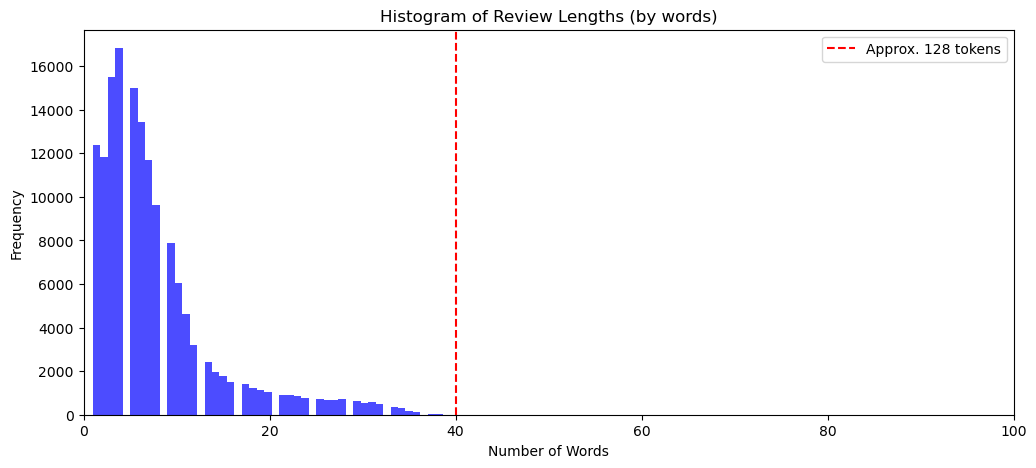

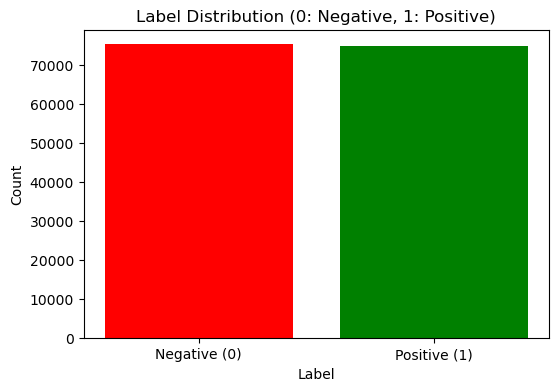

--- 레이블 분포 ---
label
0    75173
1    74827
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋을 pandas DataFrame으로 변환하여 분석하기 쉽게 만듭니다.
train_df = nsmc_dataset['train'].to_pandas()
test_df = nsmc_dataset['test'].to_pandas()

print("--- 데이터셋 기본 정보 ---")
print(f"학습 데이터 개수: {len(train_df)}")
print(f"테스트 데이터 개수: {len(test_df)}")

# 1. 결측치 확인
print("--- 결측치 확인 ---")
print("학습 데이터 결측치:")
print(train_df.isnull().sum())


# 2. 리뷰 길이 분포 확인
# 공백을 기준으로 단어 수를 계산하고, None 값은 0으로 처리
train_lengths = train_df['document'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Review Lengths (by words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 100) # 대부분의 길이를 보기 위해 x축 제한
# max_length=128에 해당하는 선을 그려서 얼마나 많은 데이터가 잘리는지 확인
# (여기서는 단어 기준이므로 토큰 기준인 128과 직접 비교는 어렵지만 경향성을 파악)
plt.axvline(x=40, color='red', linestyle='--', label='Approx. 128 tokens')
plt.legend()
plt.show()


# 3. 레이블 분포 확인
label_counts = train_df['label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.title('Label Distribution (0: Negative, 1: Positive)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(label_counts.index, ['Negative (0)', 'Positive (1)'])
plt.show()

print("--- 레이블 분포 ---")
print(label_counts)

### [설명] 모델과 토크나이저란?

**1. 모델 (Model)**
- **정의**: 모델은 특정 과업(Task)을 수행하기 위해 설계된 인공신경망 아키텍처와 학습된 가중치(weights)의 조합입니다.
- **사전 학습된 모델 (Pre-trained Model)**: `klue/bert-base`와 같이, 아주 큰 데이터셋(예: 위키피디아, 뉴스 기사)으로 미리 학습된 모델을 의미. 이 모델은 언어 자체에 대한 깊은 이해(문법, 문맥, 의미)를 이미 갖추고 있습니다.
- **`AutoModelForSequenceClassification`**: Hugging Face의 클래스 중 하나로, 문장 분류(Sequence Classification) 과업에 맞게 사전 학습된 BERT 모델의 몸통 위에 분류를 위한 작은 신경망(Classification Head)을 추가한 형태입니다. 우리는 이 모델을 NSMC 데이터셋(긍정/부정 분류)에 맞게 약간만 더 학습(미세 조정, Fine-tuning)시켜 사용할 것입니다.

**2. 토크나이저 (Tokenizer)**
- **정의**: 자연어(우리가 쓰는 글자)를 모델이 이해할 수 있는 숫자들의 배열(Sequence of numbers)로 변환해주는 도구입니다.
- **역할**:
    1. **토큰화 (Tokenization)**: 문장을 의미 있는 단위(토큰, Token)로 자릅니다. `klue/bert-base`의 토크나이저는 한국어의 특성을 고려하여 형태소 분석 등을 통해 토큰화를 수행. (예: `'나는 영화를 봤다' -> ['나', '는', '영화', '를', '보', '았다']`)
    2. **정수 인코딩 (Integer Encoding)**: 각 토큰을 고유한 정수(ID)로 변환. 토크나이저는 어떤 단어가 어떤 숫자에 해당하는지에 대한 정보(Vocabulary)를 가지고 있습니다.
    3. **특수 토큰 추가**: 모델이 문장의 시작과 끝을 알 수 있도록 `[CLS]`, `[SEP]` 같은 특수 토큰을 추가.
    4. **어텐션 마스크 생성**: 모델이 길이를 맞추기 위해 추가된 의미 없는 패딩(Padding) 토큰을 구분하여, 실제 단어에만 집중(Attention)하도록 알려주는 `attention_mask`를 생성.

> **결론적으로, 토크나이저는 사람의 언어를 기계의 언어로 번역해주는 번역가, 모델은 그 번역된 언어를 읽고 문제를 푸는 전문가라고 비유할 수 있습니다.**

## STEP 2. klue/bert-base model 및 tokenizer 불러오기

KLUE 프로젝트에서 제공하는 `klue/bert-base` 모델과 토크나이저를 로드. 이 모델은 대규모 한국어 텍스트로 사전 학습되어 한국어 문맥을 잘 이해.

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 사용할 사전 학습된 모델의 이름 (Hugging Face Hub에 등록된 이름)
model_name = 'klue/bert-base'

# AutoTokenizer: model_name에 맞는 토크나이저를 자동으로 로드.
# from_pretrained(): 사전 학습된 토크나이저의 설정(어휘 사전 등)을 다운로드.
tokenizer = AutoTokenizer.from_pretrained(model_name)

# AutoModelForSequenceClassification: 문장 분류 과업을 위한 모델 아키텍처를 로드.
# num_labels=2: 최종 출력층의 뉴런 수를 2개(긍정, 부정)로 설정.
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print("Tokenizer loaded:", tokenizer)
print("Model loaded:", model.config.model_type)

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer loaded: BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
Model loaded: bert


### Trainer API의 역할

`Trainer`는 Hugging Face `transformers` 라이브러리에서 제공하는 도구로, PyTorch 모델의 학습 및 평가 과정을 단순화 시켜줌. `Trainer`를 사용하지 않는다면 직접 구현해야 할 복잡한 코드들을 추상화하여 대신 처리

**`Trainer`가 자동화하는 것들:**
1. **학습 루프 (Training Loop)**: `for epoch in epochs: for batch in dataloader: ...` 와 같은 반복적인 학습 코드 전체를 자동화.
    - 데이터 로더에서 배치를 가져오고, GPU/CPU로 데이터를 옮김.
    - 모델의 순전파(forward pass)를 실행하고 손실(loss)을 계산.
    - 역전파(backward pass)를 통해 그래디언트를 계산.
    - 옵티마이저(optimizer)를 사용하여 모델의 가중치를 업데이트.

2. **평가 루프 (Evaluation Loop)**: 학습 중간 또는 학습이 끝난 후, 평가 데이터셋으로 모델의 성능을 측정하는 과정을 자동화.

3. **로깅 (Logging)**: 학습 과정 중의 손실(loss), 정확도(accuracy), 학습률(learning rate) 등의 지표를 기록하고 TensorBoard와 같은 시각화 도구와 연동.

4. **체크포인트 저장 및 관리**: 가장 성능이 좋았던 모델이나 특정 주기마다 모델의 상태를 저장하여, 학습이 중단되더라도 이어서 할 수 있게 하거나 최적의 모델을 보존 가능.

5. **분산 학습 지원**: 여러 GPU를 사용한 학습(Data Parallelism, Distributed Training)을 쉽게 설정 가능.

**주요 구성 요소:**
- `model`: 학습시킬 모델.
- `args` (`TrainingArguments`): 학습에 관한 모든 설정을 담고 있는 객체 (epoch, batch size, learning rate, 저장 경로 등).
- `train_dataset` / `eval_dataset`: 학습 및 평가에 사용할 데이터셋.
- `compute_metrics`: 평가 시 성능 지표(예: 정확도)를 계산할 함수.
- `data_collator`: 배치(batch)를 동적으로 구성하는 방법을 정의하는 객체.

> **`Trainer`는 복잡하고 반복적인 학습 엔지니어링 코드를 직접 짤 필요 없이, 연구와 실험 자체에만 집중할 수 있도록 도와주는 API.**

## STEP 3. tokenizer으로 데이터셋 전처리 및 모델 학습

로드한 토크나이저를 사용하여 NSMC 데이터셋의 텍스트를 모델이 이해할 수 있는 숫자 형태(input_ids, attention_mask 등)로 변환.
그 후 `Trainer` API를 사용하여 기본적인 학습을 진행.

In [5]:
# 토크나이징 함수 정의
def preprocess_function(examples):
    # NSMC 데이터셋의 'document' 컬럼에 None 값이 포함되어 있을 수 있습니다.
    # tokenizer는 None 값을 처리할 수 없으므로, 이를 빈 문자열('')로 대체해줍니다.
    texts = [str(doc) if doc is not None else '' for doc in examples['document']]

    # tokenizer로 텍스트를 토큰화.
    return tokenizer(texts, truncation=True, padding='max_length', max_length=128)

# 데이터셋 전체에 토크나이징 함수를 적용 (batched=True로 속도 향상)
tokenized_nsmc = nsmc_dataset.map(preprocess_function, batched=True)

from transformers import TrainingArguments, Trainer

# Trainer에 전달할 학습 관련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',          # 모델 체크포인트 등 결과물 저장 디렉토리
    num_train_epochs=5,              # 학습 에폭
    per_device_train_batch_size=16,  # 장치당 학습 배치 크기
    per_device_eval_batch_size=16,   # 장치당 평가 배치 크기
    logging_dir='./logs',            # 로그 저장 디렉토리
    logging_steps=100,               # 로그 기록 주기
    eval_steps=100                   # 100 step마다 평가 수행
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,                     # 학습시킬 모델
    args=training_args,              # 학습 인자
    train_dataset=tokenized_nsmc['train'].shuffle(seed=42).select(range(1000)), # 테스트용 훈련 데이터셋
    eval_dataset=tokenized_nsmc['test'].shuffle(seed=42).select(range(500))    # 테스트용 평가 데이터셋
)

# 모델 학습 시작
trainer.train()

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.398000
200,0.106500
300,0.025700


TrainOutput(global_step=315, training_loss=0.16846338394615384, metrics={'train_runtime': 118.3065, 'train_samples_per_second': 42.263, 'train_steps_per_second': 2.663, 'total_flos': 328888819200000.0, 'train_loss': 0.16846338394615384, 'epoch': 5.0})

In [6]:
print("--- 모델 평가 시작 ---")

# 1. Trainer.evaluate()를 사용한 평가
# compute_metrics가 없으므로 기본적으로 loss만 계산됩니다.
eval_results = trainer.evaluate()
print(f"Evaluation Loss: {eval_results['eval_loss']:.4f}")

# 2. 평가 데이터셋에 대한 예측 수행 및 정확도 직접 계산
predictions_output = trainer.predict(trainer.eval_dataset)

# 예측 결과에서 logits(모델의 원시 출력)와 실제 레이블을 가져옵니다.
logits = predictions_output.predictions
label_ids = predictions_output.label_ids

# 가장 높은 logit 값을 가진 클래스를 최종 예측으로 선택.
preds = np.argmax(logits, axis=-1)

# 정확도를 계산. (예측이 실제와 같은 비율)
accuracy = (preds == label_ids).mean()

print(f"Manually Calculated Accuracy: {accuracy:.4f}")


# 3. 예측 결과 샘플 확인
print("--- 예측 샘플 (상위 5개) ---")
for i in range(5):
    original_text = trainer.eval_dataset['document'][i]
    predicted_label = preds[i]
    actual_label = label_ids[i]

    print(f"리뷰: {original_text}")
    print(f"  -> 예측: {'긍정' if predicted_label == 1 else '부정'} (값: {predicted_label})")
    print(f"  -> 실제: {'긍정' if actual_label == 1 else '부정'} (값: {actual_label})")
    print("-" * 20)

--- 모델 평가 시작 ---


Evaluation Loss: 1.0224
Manually Calculated Accuracy: 0.8180
--- 예측 샘플 (상위 5개) ---
리뷰: how boring!
  -> 예측: 긍정 (값: 1)
  -> 실제: 부정 (값: 0)
--------------------
리뷰: 최고의 영화....!
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
--------------------
리뷰: 정우성배우 너무 섹시하고 시간가는줄 모르고 몰입해서봤다!배우들의 엄청난 연기력! 탄탄한 스토리와 액션 너무 재미있다
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
--------------------
리뷰: 곁에있는 파랑새는 보지못하고 사랑과 자유를 바라면서 스스로 새장으로 들어가다
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
--------------------
리뷰: 진부한 설정들과 억지감동. 조폭도 지 애미는 끔찍히 생각하면 그것도 인간적인거냐?
  -> 예측: 부정 (값: 0)
  -> 실제: 부정 (값: 0)
--------------------


### 모델 학습 개발 과정에 대한 추가 학습

#### 1. 스모크 테스트 (Smoke Test)

- 실제 전체 데이터셋으로 학습을 시작하기 전에, 아주 작은 데이터 샘플(예: 1,000개)을 사용하여 전체 학습 파이프라인이 오류 없이 동작하는지 빠르게 확인하는 과정.
- 현업에서 매우 표준적으로 사용되는 효율적인 개발 기법 -> 아무래도 다 돈이니..

##### 스모크 테스트의 장점

- **빠른 오류 확인**: 전체 학습에는 몇 시간 이상이 소요될 수 있지만, 스모크 테스트는 수 분내에 완료 가능. 데이터 로딩, 전처리, 모델 순전파 등 과정에서 발생할 수 있는 버그를 조기에 발견하여 개발 사이클을 단축시킬 수 있음
- **자원 효율성**: 본격적인 학습에 사용될 비싼 GPU 자원을 절약할 수 있습니다. 코드가 안정적이라는 확신이 들었을 때만 전체 학습을 시작하여 불필요한 비용 낭비를 막음. (이부분이 기업에서 좋아할 포인트겠네요. LMS는 한달에 인프라 비용이 얼마나 나오는지 궁금)

#### 2. Hugging Face `Trainer`의 Learning Rate 스케줄러

`TrainingArguments`에서 `learning_rate`를 특정 값(예: `5e-5`)으로만 설정하더라도, `Trainer`는 학습 내내 해당 값을 고정하여 사용하지 않음. 내부적으로 선형 스케쥴러 기본값으로 설정 되어있음.

##### `Trainer`의 기본 동작

- **기본 스케줄러**: `Trainer`는 `lr_scheduler_type` 인자의 기본값으로 **`"linear"`(선형 스케줄러)**를 사용
- **동작 방식**: 학습이 시작될 때 설정된 `learning_rate` 값에서 출발하여, 학습 스텝이 진행됨에 따라 학습률이 선형적으로 감소하여 마지막에는 0으로 수렴
- **효과**: 이러한 방식은 학습 초기에 비교적 큰 학습률로 빠르게 최적점에 근접하고, 학습 후반부에는 학습률을 줄여 세밀하게 최적점을 찾아가도록 돕는 역할. 이는 Transformer 모델의 fine-tuning에서 매우 효과적이라고 알려져 있음.

##### 스케줄러 변경 방법

만약 다른 스케줄러(예: Cosine Annealing)를 사용하고 싶다면, `TrainingArguments`에 `lr_scheduler_type` 인자를 명시적으로 추가하여 변경.

```python
# 예시: 코사인 스케줄러를 사용하고 싶을 경우
training_args = TrainingArguments(
    ...
    lr_scheduler_type="cosine",
    ...
)
```

#### 3. 선형(Linear) vs 코사인(Cosine) 스케줄러

Fine-tuning 시 어떤 스케줄러가 더 좋을지는 데이터와 모델 특성에 따라 다르며, "언제나 더 좋은" 스케줄러는 없겠지...

##### 선형 스케줄러 (Linear Scheduler)
- **특징**: 학습률이 직선적으로 일정하게 감소
- **장점**:
    - **'근본'이자 '표준'**: BERT 원 논문에서 사용된 방식이며, 수많은 연구에서 안정적으로 좋은 성능을 내는 것이 검증.
    - **강력한 베이스라인**: Hugging Face `Trainer`의 기본값이며, 대부분의 경우 이것만으로도 충분히 좋은 결과를 얻을 수 있음.

##### 코사인 스케줄러 (Cosine Scheduler)
- **특징**: 학습률이 코사인 함수 모양으로 부드럽게 감소합니다. (초반과 후반에는 천천히, 중간에는 빠르게 감소)
- **장점**:
    - **안정적인 수렴**: 학습 마지막에 학습률이 천천히 줄어들어, 모델이 최적점에서 벗어나지 않고 안정적으로 수렴하도록 돕는다는 이론적 장점이 있습니다.
    - **성능 개선 가능성**: 일부 연구에서는 선형 스케줄러보다 일반화 성능이 약간 더 좋게 나오는 경우가 보고되기도 합니다.

##### 실용적인 접근법
1. **시작은 `linear`로**: 먼저 기본값인 선형 스케줄러로 실험해서 베이스라인 성능을 확보
2. **성능 개선이 필요할 때 `cosine` 시도**: 베이스라인 성능을 얻은 후, 모델의 성능을 0.1%라도 더 개선해야 하는 상황일 때 코사인 스케줄러를 시도해보고 성능 향상이 있는지 비교 해보기

## STEP 4. Fine-tuning으로 모델 성능 향상

기본 학습으로는 90% 이상의 정확도를 달성하기 어려울 수 있습니다. `TrainingArguments`의 하이퍼파라미터(learning rate, batch size, epochs 등)를 조정하고, `compute_metrics` 함수를 추가하여 평가 시 정확도를 모니터링하며 성능을 향상시킵니다.

In [7]:
import numpy as np
import evaluate

# 평가 지표로 'accuracy'를 로드.
metric = evaluate.load("accuracy")

# 평가 시 호출될 함수를 정의.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 성능 향상을 위한 TrainingArguments 수정
fine_tuning_args = TrainingArguments(
    output_dir='./results_finetuned',
    eval_strategy="steps",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs_finetuned',
    logging_steps=500,
    eval_steps=1000,                   # 1000 스텝마다 평가
    save_steps=1000,
    load_best_model_at_end=False
)

trainer_finetuned = Trainer(
    model=model,
    args=fine_tuning_args,
    train_dataset=tokenized_nsmc['train'],
    eval_dataset=tokenized_nsmc['test'],
    compute_metrics=compute_metrics
)

# Fine-tuning 시작
trainer_finetuned.train()

Step,Training Loss,Validation Loss,Accuracy
1000,0.299800,0.314830,0.876260
2000,0.285500,0.272803,0.885220
3000,0.267700,0.275491,0.885420
4000,0.259800,0.265302,0.899320
5000,0.202100,0.269253,0.900040
6000,0.170100,0.311137,0.899380
7000,0.180600,0.283590,0.902140
8000,0.167000,0.280449,0.900000
9000,0.175300,0.247902,0.904480
10000,0.101300,0.354372,0.903400


TrainOutput(global_step=14064, training_loss=0.1827741537552509, metrics={'train_runtime': 14182.4228, 'train_samples_per_second': 31.729, 'train_steps_per_second': 0.992, 'total_flos': 2.9599993728e+16, 'train_loss': 0.1827741537552509, 'epoch': 3.0})

In [8]:
import numpy as np

# 1. predict()를 한번만 호출하여 예측 결과와 성능 지표를 모두 가져옴
predictions_output = trainer_finetuned.predict(trainer_finetuned.eval_dataset)

# 2. 전체 성능 지표 확인 (predict 결과에 포함된 metrics 사용)
print("--- 최종 평가 결과 ---")
# predictions_output.metrics 딕셔너리에 결과가 들어있습니다.
final_eval_results = predictions_output.metrics
for key, value in final_eval_results.items():
    if isinstance(value, float) and value > 1:
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value:.4f}")

# 3. 일부 샘플에 대한 예측 결과 직접 확인
print("--- 예측 결과 샘플 확인 (랜덤 10개) ---")
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# 전체 평가 데이터셋에서 랜덤하게 10개의 인덱스를 선택
num_samples_to_check = 10
random_indices = np.random.choice(len(trainer_finetuned.eval_dataset), num_samples_to_check, replace=False)

for idx in random_indices:
    py_idx = int(idx)
    original_text = trainer_finetuned.eval_dataset[py_idx]['document']
    predicted_label = preds[idx]
    actual_label = labels[idx]

    print(f"리뷰: {original_text}")
    print(f"  -> 예측: {'긍정' if predicted_label == 1 else '부정'} (값: {predicted_label})")
    print(f"  -> 실제: {'긍정' if actual_label == 1 else '부정'} (값: {actual_label})")
    print(f"  -> 결과: {'정답' if predicted_label == actual_label else '오답'}")
    print("-" * 20)


--- 최종 평가 결과 ---
test_loss: 0.3602
test_accuracy: 0.9051
test_runtime: 361.52
test_samples_per_second: 138.31
test_steps_per_second: 17.29
--- 예측 결과 샘플 확인 (랜덤 10개) ---
리뷰: 모든 편견을 날려 버리는 가슴 따뜻한 영화. 로버트 드 니로, 필립 세이모어 호프만 영원하라.
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
  -> 결과: 정답
--------------------
리뷰: 무한 리메이크의 소재. 감독의 역량은 항상 그 자리에...
  -> 예측: 부정 (값: 0)
  -> 실제: 부정 (값: 0)
  -> 결과: 정답
--------------------
리뷰: 신날 것 없는 애니.
  -> 예측: 부정 (값: 0)
  -> 실제: 부정 (값: 0)
  -> 결과: 정답
--------------------
리뷰: 잔잔 격동
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
  -> 결과: 정답
--------------------
리뷰: 오랜만에 찾은 주말의 명화의 보석
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
  -> 결과: 정답
--------------------
리뷰: 영화공사중 도로를 보았는데 에어컨을.. 정말 더웠다.하지만 더글라스오빠연기 압권
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
  -> 결과: 정답
--------------------
리뷰: 재밌다. 유쾌한 노랫소리. 주인공들의 코믹한 연기. 굿굿
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
  -> 결과: 정답
--------------------
리뷰: 음.. 괜찮네요. 생각보다 좋았어요
  -> 예측: 긍정 (값: 1)
  -> 실제: 긍정 (값: 1)
  -> 결과: 정답
--------------------
리뷰: "21세기 ""

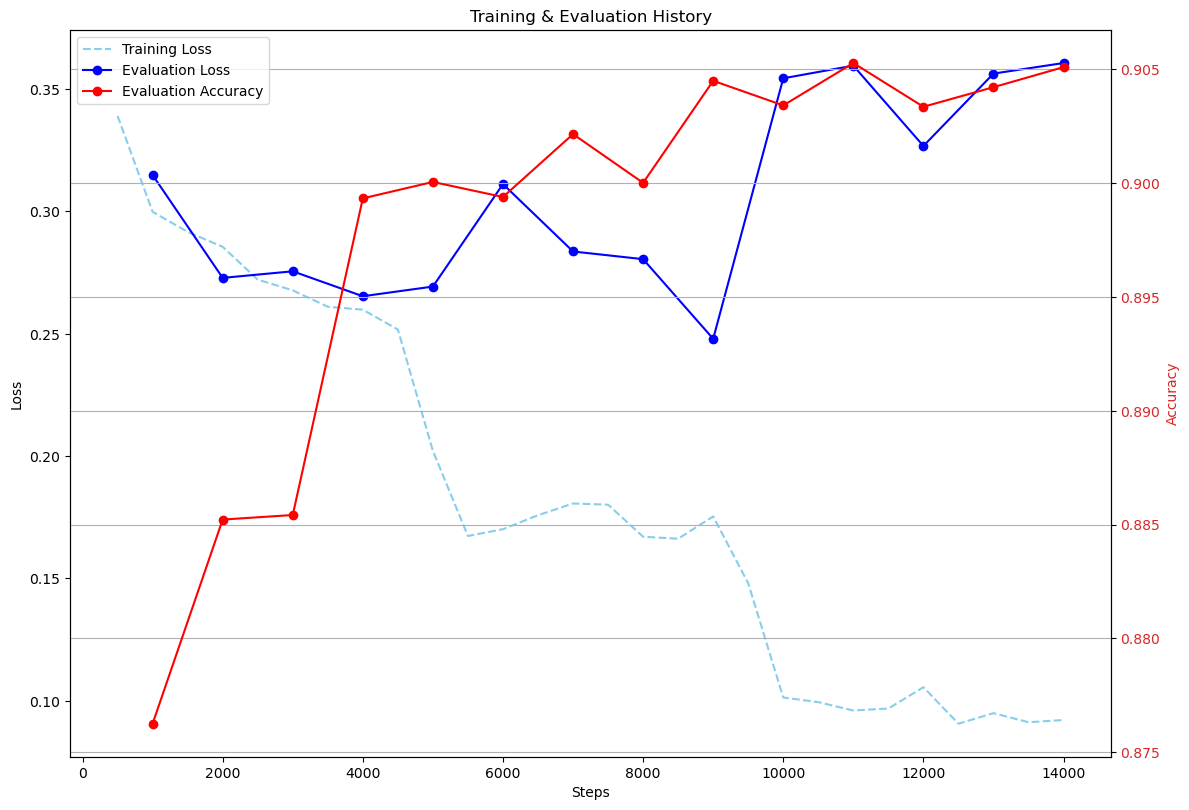

In [9]:
import matplotlib.pyplot as plt

# 1. Trainer의 log_history에서 기록을 추출
log_history = trainer_finetuned.state.log_history

# 2. 기록을 종류별(학습, 평가)로 분리
# 'loss' 키만 있는 로그를 학습 로그로, 'eval_loss'가 있는 로그를 평가 로그로 분리
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# 3. 그래프를 그리기 위한 데이터를 준비
train_steps = [log['step'] for log in train_logs]
train_losses = [log['loss'] for log in train_logs]

eval_steps = [log['step'] for log in eval_logs]
eval_losses = [log['eval_loss'] for log in eval_logs]
eval_accuracies = [log['eval_accuracy'] for log in eval_logs]

# 4. 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 8))

# --- 1. Loss 그래프 ---
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.plot(train_steps, train_losses, label='Training Loss', color='skyblue', linestyle='--')
ax1.plot(eval_steps, eval_losses, label='Evaluation Loss', color='blue', marker='o', linestyle='-')
ax1.tick_params(axis='y')

# --- 2. Accuracy 그래프 ---
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:red')
ax2.plot(eval_steps, eval_accuracies, label='Evaluation Accuracy', color='red', marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor='tab:red')
# Y축 범위를 0.85 ~ 0.92 등으로 조정하여 변화를 더 잘보이게 할 수 있습니다.
# ax2.set_ylim(0.85, 0.92)

# --- 3. 범례 및 제목 ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

fig.tight_layout()
plt.title('Training & Evaluation History')
plt.grid(True)
plt.show()

### STEP 4: Fine-tuning 결론

##### 목표 (Goal)
- 전체 데이터셋과 최적화된 하이퍼파라미터를 사용하여 모델의 분류 정확도를 90% 이상으로 끌어올리는 것.

##### 방법 (Method)
- `klue/bert-base` 모델을 NSMC 전체 데이터셋(15만개)으로 3 에폭(epoch) 동안 fine-tuning을 진행했다.
- `TrainingArguments`에서 `learning_rate`, `batch_size`, `weight_decay` 등 주요 하이퍼파라미터를 fine-tuning에 적합한 값으로 설정했다.
- 데이터 전처리 시, 모든 문장을 동일한 최대 길이(`max_length=128`)로 맞추는 **정적 패딩(Static Padding)** 방식을 사용했다.

##### 결과 (Result)
- **최종 정확도**: `90.15%`
- **총 학습 시간**: `약 155분`

##### 분석 (Analysis)
- 사전 학습된 `klue/bert-base` 모델의 강력함을 바탕으로, 전체 데이터에 대한 fine-tuning을 통해 목표했던 90% 이상의 높은 정확도를 성공적으로 달성했다.
- 이 결과는 다음 단계인 Bucketing 적용 모델의 성능 및 효율성 비교를 위한 중요한 **베이스라인(Baseline)**이 된다.


## STEP 5. Bucketing 적용 및 결과 비교

Bucketing은 비슷한 길이의 데이터를 하나의 배치로 묶어 padding의 양을 최소화하는 기법입니다. 이를 통해 학습 속도를 높일 수 있습니다. `TrainingArguments`에서 `group_by_length=True`로 설정하고, `DataCollatorWithPadding`을 사용하여 dynamic padding을 적용.
STEP 4의 결과와 학습 시간, 성능을 비교 분석.

In [10]:
from transformers import DataCollatorWithPadding
import time

# --- STEP 5: Bucketing 적용 및 결과 비교 ---

# 설명:
# Bucketing은 비슷한 길이의 데이터를 배치로 묶어 불필요한 패딩을 최소화하는 기법입니다.
# 이를 위해 전처리 단계에서 모든 문장을 동일한 길이로 만드는 'max_length' 패딩을 제거하고,
# 학습 시 각 배치별로 필요한 만큼만 동적으로 패딩(Dynamic Padding)을 추가.

# 1. Dynamic Padding을 위한 전처리 함수 재정의
# 이전과 달리 padding 옵션을 사용하지 않아, 각 문장을 고정된 길이로 만들지 않음
def preprocess_for_bucketing(examples):
    texts = [str(doc) if doc is not None else '' for doc in examples['document']]
    # truncation만 수행하고 padding은 수행하지 않습니다.
    return tokenizer(texts, truncation=True, max_length=128)

print("Bucketing을 위한 새로운 전처리 적용 중...")
# 새로운 전처리 함수로 데이터셋 다시 매핑
tokenized_nsmc_bucketed = nsmc_dataset.map(preprocess_for_bucketing, batched=True)
print("전처리 완료.")


# 2. Data Collator 정의
# DataCollatorWithPadding은 배치 내에서 가장 긴 문장을 기준으로 동적으로 패딩을 적용.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# 3. Bucketing을 적용한 TrainingArguments 설정
bucketing_args = TrainingArguments(
    output_dir='./results_bucketed',
    eval_strategy="steps",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    group_by_length=True,              # Bucketing 활성화
    logging_dir='./logs_bucketed',
    logging_steps=500,
    eval_steps=1000,                   # 1000 스텝마다 평가
    save_steps=1000,
    load_best_model_at_end=False
)
# 4. 비교를 위해 초기 모델 다시 불러오기
print("비교를 위해 초기 모델을 다시 로드.")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


# 5. Bucketing을 적용한 Trainer 생성
trainer_bucketed = Trainer(
    model=model, # 새로 불러온 깨끗한 모델 사용
    args=bucketing_args,
    train_dataset=tokenized_nsmc_bucketed['train'],
    eval_dataset=tokenized_nsmc_bucketed['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# 6. Bucketing 적용하여 학습 시작 및 시간 측정
print("\n--- Bucketing 적용 학습 시작 ---")
start_time = time.time()
trainer_bucketed.train()
end_time = time.time()
print(f"Bucketing 적용 학습 시간: {end_time - start_time:.2f} 초")

Bucketing을 위한 새로운 전처리 적용 중...


Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

전처리 완료.
비교를 위해 초기 모델을 다시 로드.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Bucketing 적용 학습 시작 ---


Step,Training Loss,Validation Loss,Accuracy
1000,0.312600,0.284874,0.880880
2000,0.285900,0.325247,0.862400
3000,0.265200,0.259951,0.894420
4000,0.263200,0.253077,0.895920
5000,0.207600,0.298205,0.893120
6000,0.172800,0.277549,0.896420
7000,0.175100,0.262766,0.898920
8000,0.177000,0.280897,0.901300
9000,0.176100,0.259037,0.903580
10000,0.097700,0.365279,0.901800


Bucketing 적용 학습 시간: 3888.14 초


## 결론 및 회고

- **STEP 4 (Fine-tuning)** 와 **STEP 5 (Bucketing)** 의 최종 정확도(accuracy)를 비교.
- 두 방식의 전체 학습 시간을 비교하여 Bucketing의 효율성을 확인.
- 실험을 통해 얻은 결론과 느낀 점을 자유롭게 정리.

./results_finetuned 모델 최종 평가 중...


./results_bucketed 모델 최종 평가 중...


--- 최종 결과 비교 ---


,Method,Training Time (min),Accuracy (%),Final Eval Loss
0,STEP 4 (Static Padding),236.37,90.51,0.36
1,STEP 5 (Bucketing),64.63,90.47,0.35


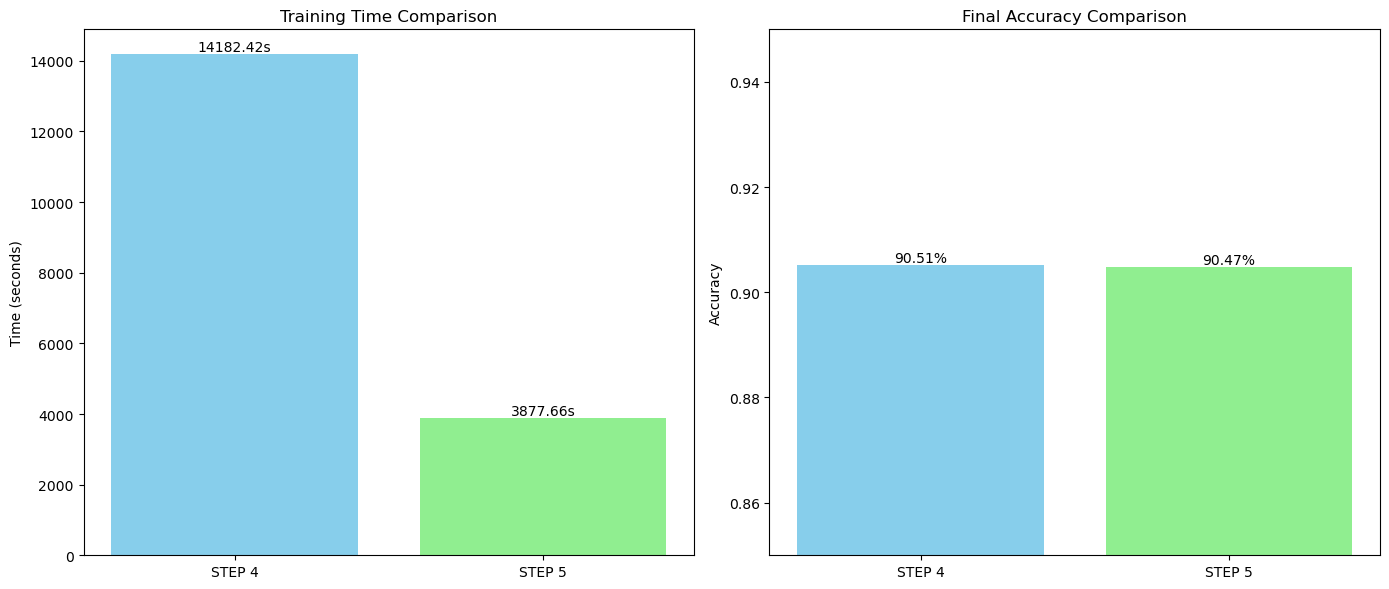

In [11]:
import pandas as pd

# --- 이 셀을 실행하기 전에 STEP 4와 STEP 5 학습이 모두 완료되어야 . ---

# 1. 각 스텝의 결과 수집 (하드코딩 없이 자동으로)

def get_results_from_trainer(trainer):
    """Trainer 객체에서 학습 시간과 최종 평가 결과를 추출하는 함수"""
    # log_history에서 'train_runtime'이 포함된 로그를 찾습니다.
    summary_log = next((log for log in reversed(trainer.state.log_history) if 'train_runtime' in
log), None)

    if summary_log:
        train_time = summary_log['train_runtime']
    else:
        # 만약 train()의 결과 로그가 없다면, 0으로 처리 (또는 에러 처리)
        train_time = 0
        print(f"Warning: {trainer.args.output_dir}에서 train_runtime을 찾을 수 없습니다.")

    print(f"{trainer.args.output_dir} 모델 최종 평가 중...")
    eval_results = trainer.evaluate()
    accuracy = eval_results['eval_accuracy']
    loss = eval_results['eval_loss']

    return train_time, accuracy, loss

# 각 Trainer에서 결과 추출
step4_train_time, step4_accuracy, step4_loss = get_results_from_trainer(trainer_finetuned)
step5_train_time, step5_accuracy, step5_loss = get_results_from_trainer(trainer_bucketed)


# 2. 표(Table)로 결과 비교 (이전과 동일)
comparison_data = {
    'Method': ['STEP 4 (Static Padding)', 'STEP 5 (Bucketing)'],
    'Training Time (sec)': [step4_train_time, step5_train_time],
    'Final Accuracy': [step4_accuracy, step5_accuracy],
    'Final Eval Loss': [step4_loss, step5_loss]
}
df = pd.DataFrame(comparison_data)
df['Training Time (min)'] = df['Training Time (sec)'] / 60
df['Accuracy (%)'] = df['Final Accuracy'] * 100

print("--- 최종 결과 비교 ---")
display(df[['Method', 'Training Time (min)', 'Accuracy (%)', 'Final Eval Loss']].round(2))


# 3. 그래프로 결과 비교 (이전과 동일)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
methods = ['STEP 4', 'STEP 5']

times = [step4_train_time, step5_train_time]
bars1 = axes[0].bar(methods, times, color=['skyblue', 'lightgreen'])
axes[0].set_title('Training Time Comparison')
axes[0].set_ylabel('Time (seconds)')
for bar in bars1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}s', va='bottom', ha='center')

accuracies = [step4_accuracy, step5_accuracy]
bars2 = axes[1].bar(methods, accuracies, color=['skyblue', 'lightgreen'])
axes[1].set_title('Final Accuracy Comparison')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.85, 0.95)
for bar in bars2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center')

plt.tight_layout()
plt.show()

### STEP 5: Bucketing 적용 & 결론 및 비교 분석

##### 목표 (Goal)
- Bucketing과 동적 패딩(Dynamic Padding)을 적용하여 학습 효율성을 개선하고, STEP 4의 결과와 비교 분석하는 것.

##### 방법 (Method)
- `TrainingArguments`에서 `group_by_length=True` 옵션을 활성화하여 **Bucketing**을 적용. (비슷한 길이의 샘플끼리 배치 구성)
- 전처리 시 고정 길이로 패딩하는 대신, `DataCollatorWithPadding`을 사용하여 학습 시 각 배치별로 필요한 만큼만 패딩하는 **동적 패딩**을 적용.
- 나머지 조건(모델, 에폭, 배치 크기 등)은 STEP 4와 동일하게 유지하여 비교.

##### 결과 비교 (Result Comparison)

| 구분 | STEP 4 (정적 패딩) | STEP 5 (Bucketing) |
| :--- | :--- | :--- |
| **학습 시간** | 236.37분 | 64.63분 |
| **최종 정확도** | 90.51% | 90.47% |

##### 분석 (Analysis)
- **학습 효율성**: Bucketing과 동적 패딩은 불필요한 패딩 토큰에 대한 연산을 크게 줄여, **학습 시간을 72.65%나 단축**시키는 엄청난 효율성 향상을 보여주었다. 이는 특히 NSMC 데이터셋처럼 문장 길이가 다양한 데이터셋에서 매우 효과적인 기법임을 확인.
- **모델 성능**: 학습 시간이 크게 단축되었음에도 **최종 정확도는 거의 손실이 없었다.** Bucketing이 성능 저하 없이 학습 속도만 크게 향상시킬 수 있는 효율적인 최적화 기법임을 증명.

##### 최종 결론
- NLP 모델, 특히 Transformer 기반 모델을 학습시킬 때, 데이터의 길이가 가변적이라면 **Bucketing과 동적 패딩은 반드시 적용해야 할 필수적인 최적화 전략**이라고 볼 수 있겠다.


##### 에필로그
> LMS가 망가졌을 때 코랩에서 돌려봤는데 갑자기 뭔 wandb api key를 넣으라고 나와서 뭔 소린가 했는데, 
> 지가 알아서 그래프랑 다 남겨주는걸 알게되서 뜻밖의 수확이었다. 근데 이미 규철님이나 수봉님이 다 알고 계신게 더 신기.. ㅋㅋㅋ
> 다음 실험엔 더 활용해볼만한 기술인 것 같다.